In [4]:
#%matplotlib widget

#https://people.duke.edu/~ccc14/sta-663/CalibratingODEs.html
from lmfit import minimize, Parameters, report_fit, fit_report
from scipy.integrate import odeint
from collections import defaultdict
import matplotlib.pyplot as plt
import os
import pandas as pd
import numpy as np
import copy

from datetime import datetime
now = datetime.now()
date = now.strftime("%d%b%Y")


mpl_colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']
mpl_colors_dark = ['#005794', '#df5f0e', '#0c800c', '#b60708', '#74479d', '#6c362b', '#b357a2', '#5f5f5f', '#9c9d02', '#079eaf']


In [5]:
#Reads in time vs response BLI data from OctetR8 export csv file
pd.set_option("future.no_silent_downcasting", True)
def read_bli_data(data_file):
    units = {'nm':1.0e-9,'um':1.0e-6,'mm':1.0e-3,'m':1.0}

    data = pd.read_csv(data_file,skiprows=4)
    data = data[data.columns.drop(' ')]
    #display(data)
    header = pd.read_csv(data_file,skiprows=3,nrows=1,header=None)
    header = header.replace(" ",float("NaN"))
    header = header.dropna(how='all',axis=1)
    #display(header)
    header2 = pd.read_csv(data_file,skiprows=2,nrows=1,header=None)
    header2 = header2.astype(str).replace(" ",float("NaN"))
    header2 = header2.dropna(how='all',axis=1)
    #display(header2)
    data_id = pd.read_csv(data_file,skiprows=1,nrows=1,header=None)
    d_id = {}
    for i,hc in enumerate(data_id.columns[::2]):
        d_id[i] = data_id[hc].str.strip()[0]

    sample_loc = {}
    sample_id = {}
    for i,hc in enumerate(header2.columns[::2]):
        sample_loc[i] = header2[hc].str.split(':',expand=True)[1][0].strip()
        sample_id[i] = header2[hc+1].str.split(':',expand=True)[1][0].strip()

    #get concentrations from header text
    conc = {}
    for i,hc in enumerate(header.columns[::2]):
        #df[[str(j),str(j+1)]] = header[hc].str.split(':',expand=True)
        concj = header[hc].str.split(':',expand=True)[1][0].strip()
        unitj = header[hc+1].str.split(':',expand=True)[1][0].strip().lower()
        #unitj = unitj.strip().lower()
        conc[i] = float(concj) * units[unitj]

    bli_data = pd.DataFrame()
    for i,dc in enumerate(data.columns[::2]):
        bli_timept = pd.DataFrame()
        bli_timept['time_raw'] = data[dc]
        bli_timept['response'] = data.iloc[:,[i*2+1]]
        bli_timept['conc'] = conc[i]
        bli_timept['location'] = sample_loc[i]
        bli_timept['sampleID'] = sample_id[i]
        bli_timept['dataID'] = d_id[i]
        bli_timept['time'] = bli_timept['time_raw'] - bli_timept['time_raw'].min()
        bli_data = pd.concat([bli_data,bli_timept],ignore_index=True)
    return bli_data

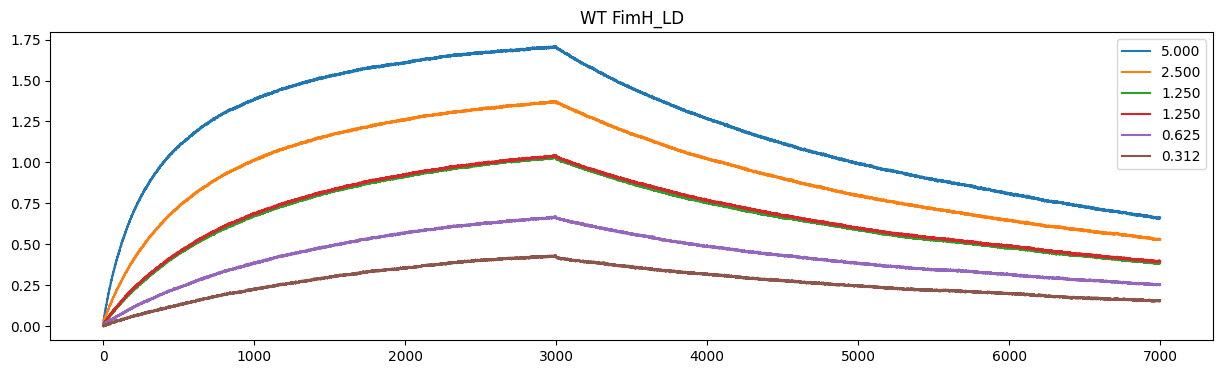

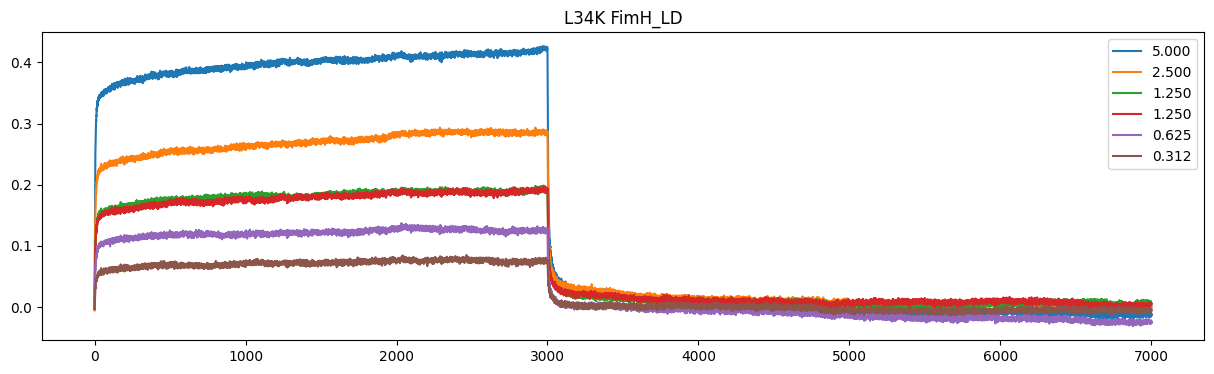

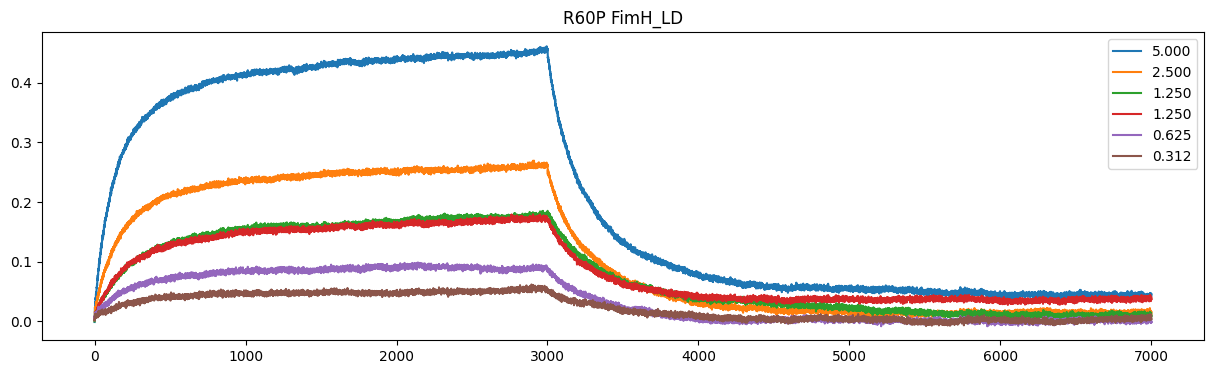

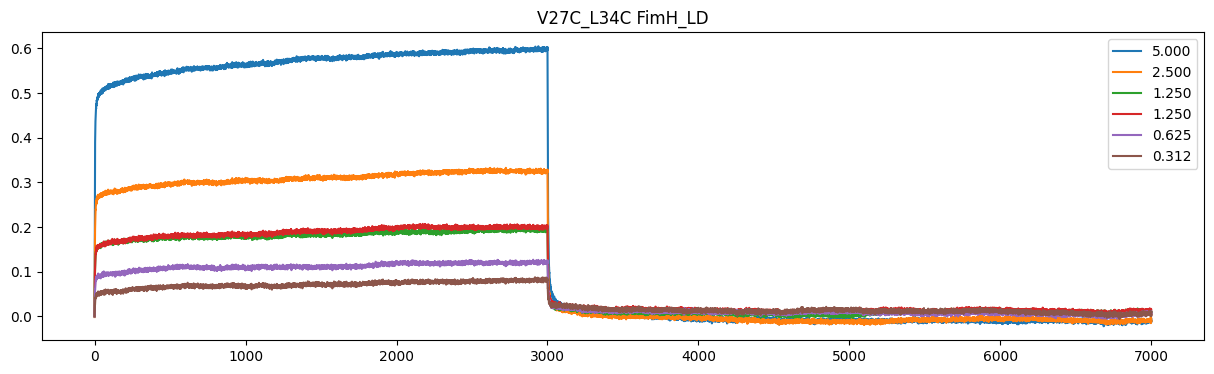

In [6]:
DATA_DIR = os.getcwd()
Output_DIR = DATA_DIR
#if not os.path.exists(Output_DIR): os.makedirs(Output_DIR)
samples = ['WT FimH_LD','L34K FimH_LD','R60P FimH_LD','V27C_L34C FimH_LD']
data_files = [os.path.join(DATA_DIR,'FimH_WTLD_octet_data.csv'),
              os.path.join(DATA_DIR,'FimH_L34KLD_octet_data.csv'),
              os.path.join(DATA_DIR,'FimH_R60PLD_octet_data.csv'),
              os.path.join(DATA_DIR,'FimH_V27CL34CLD_octet_data.csv'),
              ]
Tswitches = [3000, 3000, 3000, 3000, 3000]
conc_adj_factor = [1.0,1.0,1.0,1.0,1.0]  #conc = labeled conc * adj

bli_data_all = pd.DataFrame()

Drop = [1.0, 0, 0,0,0] #drop values Tswitch + 1.0 sec,

for sample in samples:
    i = samples.index(sample)
    shift = 0.0
    Tswitch = Tswitches[i]
    
    bli_data = pd.DataFrame()
    bli_data = read_bli_data(data_files[i])
    bli_data['sample']=sample
    
    runs = bli_data['dataID'].unique()
    bli_data['response_unadj'] = bli_data['response']
    bli_data['conc_unadj'] = bli_data['conc']
    bli_data['conc'] = bli_data['conc']*conc_adj_factor[i]

    fig,ax=plt.subplots(figsize=(15,4))
    if Drop[i] > 0:
        for r in runs:
            high = bli_data.loc[(bli_data.dataID == r) & (bli_data.time == Tswitch)]['response'].values[0]
            low = bli_data.loc[(bli_data.dataID == r) & (bli_data.time == Tswitch+Drop[i])]['response'].values[0]
            shift = high - low
            mask = (bli_data['dataID']==r) & (bli_data['time'] > Tswitch+Drop[i])
            bli_cur = bli_data[mask]
            bli_data.loc[mask,'response'] = bli_cur['response_unadj'] + shift
        bli_data = bli_data[~bli_data['time'].between(Tswitch, Tswitch + Drop[i],inclusive='right')]

    for r in runs:
        x = bli_data[(bli_data.dataID == r)]['time'].values
        y = bli_data[(bli_data.dataID == r)]['response'].values
        label = format(bli_data[bli_data.dataID == r]['conc'].values[0]*1e6,'0.3f')
        ax.plot(x,y,label=label)
    ax.legend();
    ax.set_title(sample)
    bli_data_all = pd.concat([bli_data_all,bli_data])

#bli_data_all.to_csv(os.path.join(DATA_DIR,'FimH_OctetData_ALL_03Feb2025.csv'),index_label='Index',mode='w')

conc: 5.00e-06


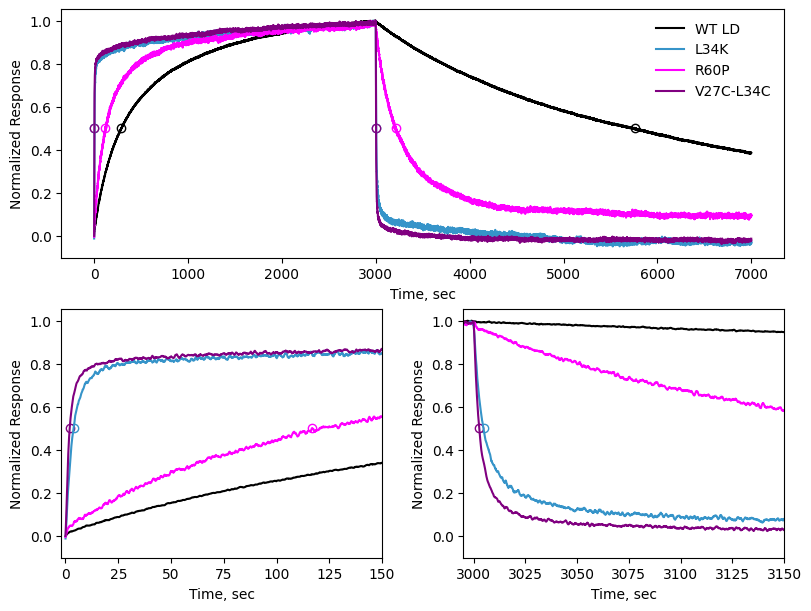

conc: 2.50e-06


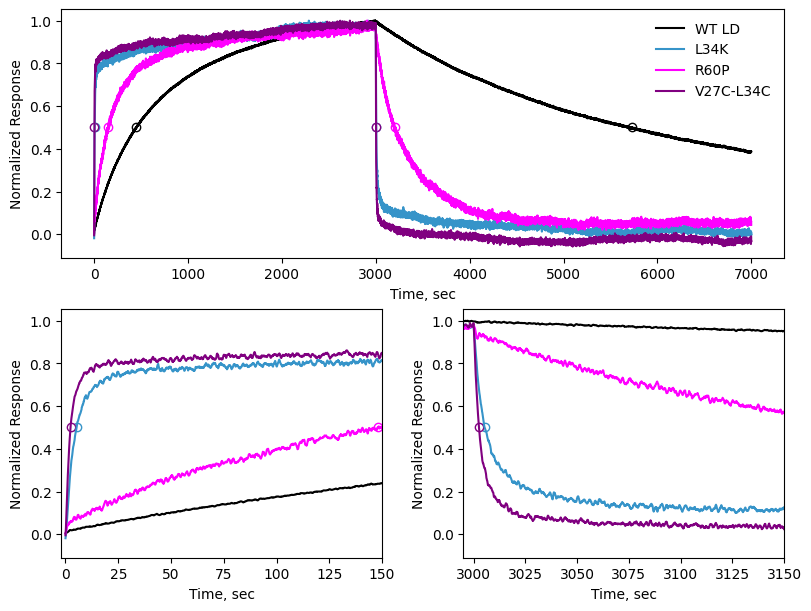

conc: 1.25e-06


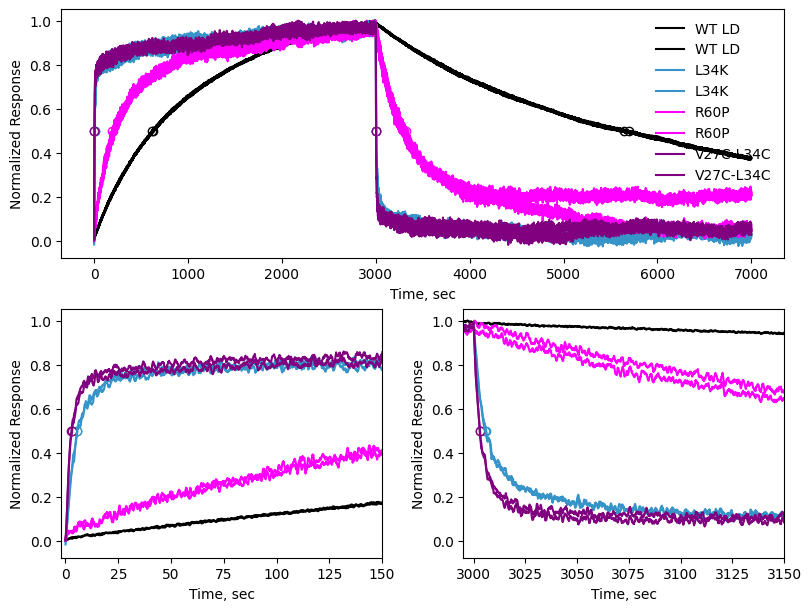

conc: 6.25e-07


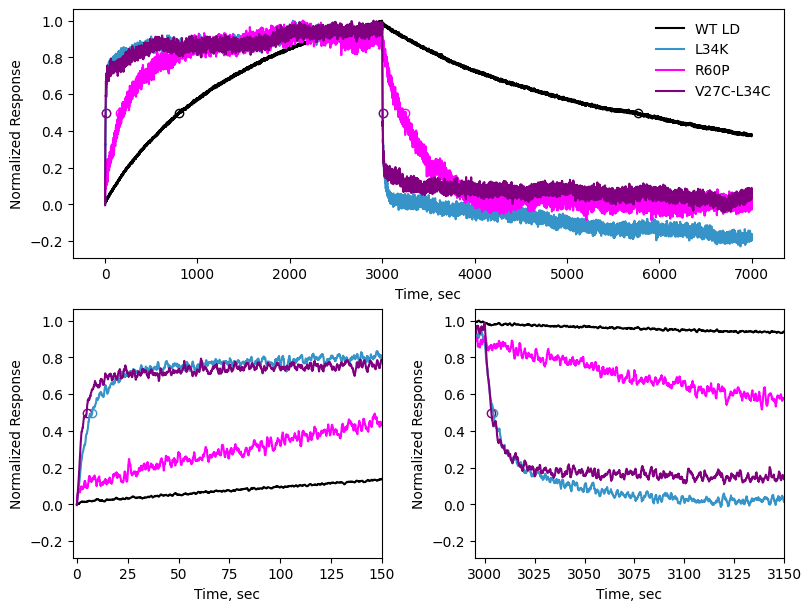

conc: 3.12e-07


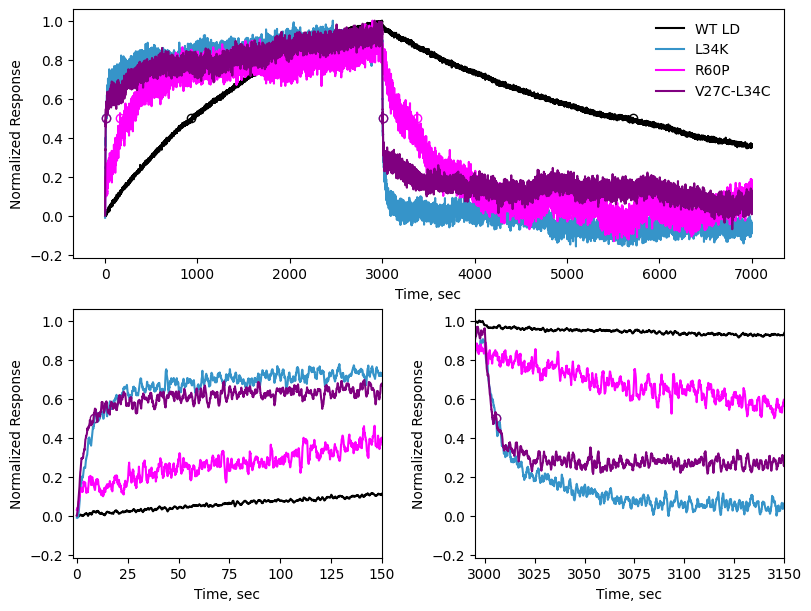

,Sample,conc,run,t1/2_on,t1/2_off
0,WT LD,5.000000e-06,0,288.3,2757.8
1,L34K,5.000000e-06,0,3.9,4.8
2,R60P,5.000000e-06,0,116.7,214.9
3,V27C-L34C,5.000000e-06,0,2.0,2.7
4,WT LD,2.500000e-06,0,447.0,2730.4
5,L34K,2.500000e-06,0,5.3,5.3
6,R60P,2.500000e-06,0,147.9,207.7
7,V27C-L34C,2.500000e-06,0,2.4,2.5
8,WT LD,1.250000e-06,0,623.8,2642.6
9,WT LD,1.250000e-06,1,616.9,2693.7


In [7]:
from matplotlib.gridspec import GridSpec
#from scipy.signal import savgol_filter

save = False #True
samps = samples
colorsm = {'WT FimH_LD':'black','R60P FimH_LD':'magenta','L34K FimH_LD':'#3694C9', 'V27C_L34C FimH_LD':'purple'}
labels = {'WT FimH_LD':'WT LD','R60P FimH_LD':'R60P','L34K FimH_LD':'L34K', 'V27C_L34C FimH_LD':'V27C-L34C'}
Tswitch = 3000

#use_conc = bli_data_all['conc'].unique()[0]
#fig,ax=plt.subplots(nrows=3,ncols=1,figsize=(15,12))
halflife = pd.DataFrame()
for use_conc in bli_data_all[bli_data_all['sample'].isin(samps)]['conc'].unique():#[0:1]:
    print("conc:","{:.2e}".format(use_conc))
    fig = plt.figure(constrained_layout=True,figsize=(8,6))

    gs = GridSpec(2, 2, figure=fig)
    ax0 = fig.add_subplot(gs[0, :])
    # identical to ax1 = plt.subplot(gs.new_subplotspec((0, 0), colspan=3))
    ax1 = fig.add_subplot(gs[1, :-1])
    ax2 = fig.add_subplot(gs[1:, -1])
   

    for samp in samps:
        for i,loc in enumerate(bli_data_all[(bli_data_all['sample']==samp) & (bli_data_all['conc']==use_conc)]['location'].unique()):
            s = samples.index(samp)
            t = bli_data_all[(bli_data_all['sample']==samp) & (bli_data_all['conc']==use_conc) & (bli_data_all['location']==loc) ]['time'].values
            response = bli_data_all[(bli_data_all['sample']==samp) & (bli_data_all['conc']==use_conc)& (bli_data_all['location']==loc)]['response'].values
            #sid = bli_data_all[(bli_data_all['sample']==samp) & (bli_data_all['conc']==use_conc)]['sampleID'].values[0]
            sid = labels[samp]
            #print(samp,sid)
            response = response/np.max(response)
            t_half_on = t[np.argmax(response>0.5)]
            t_half_off = t[::-1][np.argmax(response[::-1]>0.5)]
            #print(sid,"{:.0f}".format(t_half_on),"{:.0f}".format(t_half_off-3000))
            ax0.plot(t,response,label=sid,color=colorsm[samp])
            ax0.scatter([t_half_on,t_half_off],[0.5,0.5],marker='o',edgecolor=colorsm[samp],color='w')
            ax1.plot(t,response,color=colorsm[samp])
            ax1.scatter([t_half_on,t_half_off],[0.5,0.5],marker='o',edgecolor=colorsm[samp],color='w')
            ax1.set_xlim(-2,150)
            ax2.plot(t,response,color=colorsm[samp])
            ax2.scatter([t_half_on,t_half_off],[0.5,0.5],marker='o',edgecolor=colorsm[samp],color='w')
            ax2.set_xlim(Tswitch-5,Tswitch+150)
            halflife = pd.concat([halflife,pd.DataFrame({'Sample':[sid],'conc':[use_conc],'run':[i],'t1/2_on':[t_half_on],'t1/2_off':[t_half_off-3000]})],ignore_index=True)
        for i,axi in enumerate(fig.axes):
            axi.set_ylabel("Normalized Response")
            axi.set_xlabel("Time, sec")
    ax0.legend(frameon=False);
    plt.show()
if save: 
    fig.savefig(os.path.join(Output_DIR,'FimH_BLI_overlay_5uMresponse_'+date+'.pdf'),format='pdf',dpi=600,bbox_inches = 'tight')
    fig.savefig(os.path.join(Output_DIR,'FimH_BLI_overlay_5uMresponse_'+date+'.svg'),format='svg',bbox_inches='tight')


# for i,s in enumerate(samps):
#     halflife.loc[halflife[(halflife['Sample'] == labels[s])].index,'order'] = i
# halflife = halflife.sort_values(by=['order','conc','run']).reset_index(drop=True)[['Sample','conc','run','t1/2_on','t1/2_off']]

display(halflife)
   

In [8]:
halflife.groupby('Sample').agg({'t1/2_off':['mean','std']})

t1/2_off           
                  mean        std
Sample                           
L34K          5.233333   0.598888
R60P        279.533333  66.937244
V27C-L34C     3.350000   1.224337
WT LD      2716.850000  44.943909